## DGCCA CelebA

In [1]:
from collections import OrderedDict, namedtuple
from itertools import product
import os
from tqdm import tqdm, trange
from IPython.display import clear_output
import time
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from utils.run_manager import RunBuilder
from models import g_step, CelebaDGCCA
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

if torch.cuda.is_available():
    devices = ['cuda']
else:
    devices = ['cpu']
print('starting')


params = OrderedDict(
    lr = [0.001],
    batch_size = [1000],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    manual_seed = [1265],
    loss_func = [nn.MSELoss]
)

# layer_sizes_list = 3*[[128, 64, 2]]
# input_size_list = 3*[2]


run_count = 0
models = []


run_data = []

data_load_time = 0
forward_time = 0


for run in RunBuilder.get_runs(params):
#     torch.cuda.set_device(run.device)
    
    run_count += 1
    device = torch.device(run.device)
    
    dgcca = CelebaDGCCA()
    dgcca = dgcca.to(device)

    transform = transforms.Compose(
        [
            transforms.Resize(64),
            transforms.CenterCrop(64),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    )

    dataset = datasets.ImageFolder('/scratch/sagar/Projects/flow/glow-pytorch/data/img_align_celeba', transform=transform)
    dataloader = DataLoader(dataset, shuffle=False, batch_size=run.batch_size, num_workers=4)
    dataloader = iter(dataloader)

    train_views, _ = next(dataloader)
    val_views = train_views[:1000,:,:,:].clone()
    train_views_cpu = [train_views[:,i,:,:] for i in range(train_views.shape[1])]
    train_views = [view.to(device).unsqueeze(dim=1) for view in train_views_cpu]
    train_views_cpu = [view.to(device).unsqueeze(dim=1) for view in train_views_cpu]
    
#     val_views, _ = next(dataloader)
    
    val_views = [val_views[:,i,:,:] for i in range(val_views.shape[1])]
    val_views = [view.to(device).unsqueeze(dim=1) for view in val_views]
    
    optimizer = torch.optim.Adam(dgcca.parameters(), lr=run.lr)
    num_batches = len(train_views[0])//200
    
    criterion = run.loss_func()
    num_val_batches = len(val_views[0])//200
    
    dgcca.eval()
    dgcca = dgcca.to('cpu')
    out = dgcca(train_views_cpu)
    out = torch.stack(out)  
    G = g_step(out.clone().detach())  
    M_serv = out.clone()
    M_diff = out.clone()
    
    I = len(train_views)
    
    for epoch in range(100):
        total_recons_loss = 0
        total_val_loss = 0
        batch_count = 0
        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/num_batches
        results['val_fidelity'] = total_recons_loss/num_batches
        
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device

        df3 = pd.DataFrame.from_dict(run_data, orient='columns')
        
        for i in range(num_batches):
            optimizer.zero_grad()
            batch = []
#             batch = [view[(i*run.batch_size):((i+1)*run.batch_size), :] for view in train_views]            
#             target = G[(i*run.batch_size):((i+1)*run.batch_size), :]
            
#             batch = [view.to(device).unsqueeze(dim=1) for view in batch]
            
            # full gradient
            batch = train_views
            target = G
            
            out = dgcca(batch)
            out = torch.stack(out)  
            # G = g_step(out.clone().detach())
            loss = 1/3*torch.norm(out-target)
            loss.backward()
            optimizer.step()
            total_recons_loss += loss.item()
            
        ## initialize G
        out = dgcca(train_views)
        out = torch.stack(out)
        
        for i in range(I):
            M_diff[i] = out[i] - M_serv[i]
            max_val = M_diff[i].abs().max()
            M_quant = ((1/max_val)*M_diff[i]).round()*(max_val/1)
            M_serv[i] += M_quant
        G = g_step(M_serv.clone().detach())    

        # validation loss
        out_val = dgcca(val_views)
        out_val = torch.stack(out_val)
        G_val = g_step(out_val.clone().detach())
        loss_val = criterion(out_val, G_val)
        total_val_loss += loss_val.item()

        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/num_batches/10
        results['val_fidelity'] = total_val_loss
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device
        
        run_data.append(results)
        df2 = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
#         show_latent()
        display(df2)
            
#             m.track_loss(G_adv_loss=losses['beta_kl-divergence'], G_mse_loss=losses[''], D_real_loss=total_D_real, D_fake_loss=total_D_fake, D_real_count=real_count, D_fake_count=fake_count)
#         print(epoch, "total_Gloss:",total_Gloss, "total_Dloss:",total_Dloss, "mse:",total_mse_loss, "adv: ", total_adv_loss)           
#         m.end_epoch()
        torch.save(dgcca, 'trained_models/dgcca_celeba.model')

,run_count,epoch,data_fidelity,val_fidelity,batch_size,lr,device
0,1,0,2.388504,0.039285,1000,0.001,cuda
1,1,1,0.938792,0.012180,1000,0.001,cuda
2,1,2,0.601284,0.005594,1000,0.001,cuda
3,1,3,0.475366,0.004040,1000,0.001,cuda
4,1,4,0.386858,0.001990,1000,0.001,cuda
5,1,5,0.329158,0.002183,1000,0.001,cuda
6,1,6,0.309780,0.002006,1000,0.001,cuda


RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 10.92 GiB total capacity; 9.14 GiB already allocated; 12.00 MiB free; 9.20 GiB reserved in total by PyTorch)

## DGCCA CIFAR10

In [9]:
from collections import OrderedDict, namedtuple
from itertools import product
import os
from tqdm import tqdm, trange
from IPython.display import clear_output
import time
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from utils.run_manager import RunBuilder
from models import g_step, CifarDGCCALabeled
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import torchvision

class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

if torch.cuda.is_available():
    devices = ['cpu']
else:
    devices = ['cpu']
print('starting')


params = OrderedDict(
    lr = [0.001],
    batch_size = [1000],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    manual_seed = [1265],
    loss_func = [nn.MSELoss],
    quant = [False]
)

# layer_sizes_list = 3*[[128, 64, 2]]
# input_size_list = 3*[2]


run_count = 0
models = []


run_data = []

data_load_time = 0
forward_time = 0


for run in RunBuilder.get_runs(params):
#     torch.cuda.set_device(run.device)
    
    run_count += 1
    device = torch.device(run.device)
    
    dgcca = CifarDGCCALabeled()
    dgcca = dgcca.to(device)

    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #torchvision.transforms.Normalize(mean, std)

    train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=50000,
                                              shuffle=True, num_workers=5)

    test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=5000,
                                             shuffle=True, num_workers=5)

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    train_loader = iter(train_loader)
    test_loader = iter(test_loader)
    
    train_views, train_classes = next(train_loader)
    val_views, val_classes = next(test_loader)
    
    train_views = [train_views[:,i,:,:] for i in range(train_views.shape[1])]
    train_views = [view.to(device).unsqueeze(dim=1) for view in train_views]
    
    val_views = [val_views[:,i,:,:] for i in range(val_views.shape[1])]
    val_views = [view.to(device).unsqueeze(dim=1) for view in val_views]
    
    one_hot_train = torch.zeros((len(train_classes), 10))
    one_hot_train[torch.arange(len(train_classes)), train_classes] = 1
    train_views.append(one_hot_train.to(device))
    
    one_hot_val = torch.zeros((len(val_classes), 10))
    one_hot_val[torch.arange(len(val_classes)), val_classes] = 1
    val_views.append(one_hot_val.to(device))
    
    optimizer = torch.optim.Adam(dgcca.parameters(), lr=run.lr)
    num_batches = len(train_views[0])//1000
    
    criterion = run.loss_func()
    num_val_batches = len(val_views[0])//1000
    
    out = torch.stack(dgcca(train_views))
#     out = torch.stack(out)  
    G = g_step(out.clone().detach())  
    
    M_serv = out.clone()
    M_diff = out.clone()
    
    I = len(train_views)
    
    for epoch in range(100):
        total_recons_loss = 0
        total_val_loss = 0
        batch_count = 0
        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/num_batches
        results['val_fidelity'] = total_recons_loss/num_batches
        
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device

        df2 = pd.DataFrame.from_dict(run_data, orient='columns')
        
        for i in range(num_batches):
            optimizer.zero_grad()
            batch = []
            
            # mini batch gradient
            batch = [view[(i*run.batch_size):((i+1)*run.batch_size), :] for view in train_views]            
            target = G[(i*run.batch_size):((i+1)*run.batch_size), :]
            
            # full gradient
#             batch = train_views
#             target = G
#             print(batch[0].shape)
#             out = dgcca(batch)
#             out = torch.stack(out)  

            loss = 1/2*torch.norm(torch.stack(dgcca(batch))-target)/target.shape[0]
            
            loss.backward()
            optimizer.step()
            
            total_recons_loss += loss.item()
            
        ## initialize G
#         out = dgcca(train_views)
        dgcca.eval()
        out = torch.stack(dgcca(train_views))
        
        if run.quant:
            for i in range(I):
                M_diff[i] = out[i] - M_serv[i]
                max_val = M_diff[i].abs().max()
                M_quant = ((1/max_val)*M_diff[i]).round()*(max_val/1)
                M_serv[i] += M_quant
            G = g_step(M_serv.clone().detach())    
        else:
            G = g_step(out.clone().detach())    
            
        # validation loss
        out_val = dgcca(val_views)
        out_val = torch.stack(out_val)
        
        G_val = g_step(out_val.clone().detach())
        
        loss_val = criterion(out_val, G_val)
        total_val_loss += loss_val.item()

        dgcca.train()
        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/num_batches/10
        results['val_fidelity'] = total_val_loss
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device
        
        run_data.append(results)
        df2 = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
#         show_latent()
        display(df2)
            
#             m.track_loss(G_adv_loss=losses['beta_kl-divergence'], G_mse_loss=losses[''], D_real_loss=total_D_real, D_fake_loss=total_D_fake, D_real_count=real_count, D_fake_count=fake_count)
#         print(epoch, "total_Gloss:",total_Gloss, "total_Dloss:",total_Dloss, "mse:",total_mse_loss, "adv: ", total_adv_loss)           
#         m.end_epoch()
        torch.save(dgcca, 'trained_models/dgcca_cifar10_labeled.model')

,run_count,epoch,data_fidelity,val_fidelity,batch_size,lr,device
0,1,0,0.000860,0.001158,1000,0.001,cpu
1,1,1,0.000292,0.000563,1000,0.001,cpu
2,1,2,0.000230,0.000418,1000,0.001,cpu
3,1,3,0.000200,0.000374,1000,0.001,cpu
4,1,4,0.000181,0.000295,1000,0.001,cpu
...,...,...,...,...,...,...,...
95,1,95,0.000027,0.000116,1000,0.001,cpu
96,1,96,0.000027,0.000115,1000,0.001,cpu
97,1,97,0.000027,0.000116,1000,0.001,cpu
98,1,98,0.000027,0.000115,1000,0.001,cpu


In [ ]:
## MNIST view

In [2]:
out[0].shape

NameError: name 'out' is not defined

In [2]:
import torch
torch.zeros((33))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [13]:
one_hot = torch.zeros((len(train_classes), 10))
one_hot[torch.arange(len(train_classes)), train_classes] = 1

In [22]:
one_hot[-3]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [16]:
train_classes

tensor([6, 9, 9,  ..., 9, 1, 1])

In [12]:
torch.arange(10)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
a = np.array([1, 0, 3])
>>> b = np.zeros((a.size, a.max()+1))
>>> b[np.arange(a.size),a] = 1

## Federated GCCA Cifar10

In [1]:
from collections import OrderedDict, namedtuple
from itertools import product
import os
from tqdm import tqdm, trange
from IPython.display import clear_output
import time
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from utils.run_manager import RunBuilder
from models import g_step, CifarDGCCA
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import torchvision

class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

if torch.cuda.is_available():
    devices = ['cpu']
else:
    devices = ['cpu']
print('starting')


params = OrderedDict(
    lr = [0.001],
    batch_size = [1000],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    manual_seed = [1265],
    loss_func = [nn.MSELoss],
    quant = [True]
)

# layer_sizes_list = 3*[[128, 64, 2]]
# input_size_list = 3*[2]


run_count = 0
models = []


run_data = []

data_load_time = 0
forward_time = 0


for run in RunBuilder.get_runs(params):
#     torch.cuda.set_device(run.device)
    
    run_count += 1
    device = torch.device(run.device)
    
    dgcca = CifarDGCCA()
    dgcca = dgcca.to(device)

    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #torchvision.transforms.Normalize(mean, std)

    train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=50000,
                                              shuffle=False, num_workers=5)

    test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=5000,
                                             shuffle=False, num_workers=5)

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    train_loader = iter(train_loader)
    test_loader = iter(test_loader)
    
    train_views, _ = next(train_loader)
    val_views, _ = next(test_loader)
    
    train_views = [train_views[:,i,:,:] for i in range(train_views.shape[1])]
    train_views = [view.to(device).unsqueeze(dim=1) for view in train_views]
    
    val_views = [val_views[:,i,:,:] for i in range(val_views.shape[1])]
    val_views = [view.to(device).unsqueeze(dim=1) for view in val_views]
    
    optimizer = torch.optim.Adam(dgcca.parameters(), lr=run.lr)
    num_batches = len(train_views[0])//run.batch_size
    
    criterion = run.loss_func()
    num_val_batches = len(val_views[0])//1000
    
    out = torch.stack(dgcca(train_views))
    G = g_step(out.clone().detach())  
    
    M_serv = out.detach().clone()
    
    I = len(train_views)
    
    for epoch in range(100):
        total_recons_loss = 0
        total_val_loss = 0
        batch_count = 0
        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/num_batches
        results['val_fidelity'] = total_recons_loss/num_batches
        
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device

        df3 = pd.DataFrame.from_dict(run_data, orient='columns')
        
        for i in range(num_batches):
            optimizer.zero_grad()
            batch = []
            
            # mini batch gradient
            batch = [view[(i*run.batch_size):((i+1)*run.batch_size), :] for view in train_views]            
            target = G[(i*run.batch_size):((i+1)*run.batch_size), :]


            loss = 1/2*torch.norm(torch.stack(dgcca(batch))-target)/target.shape[0]
            
            loss.backward()
            optimizer.step()
            
            total_recons_loss += loss.item()
            
            del batch, target
            
        ## initialize G
#         out = dgcca(train_views)
        out = torch.stack(dgcca(train_views)).detach().clone()
        
        if run.quant:
            for i in range(I):
                diff = out[i] - M_serv[i]
                max_val = diff.abs().max()
                quant = ((1/max_val)*diff[i]).round()*(max_val/1)
                var = M_serv[i] + quant
                M_serv[i] = var
                del max_val, diff, quant, var
            G = g_step(M_serv.clone().detach())
        else:
            G = g_step(out.clone().detach())
            
        # validation loss
        out_val = dgcca(val_views)
        out_val = torch.stack(out_val)
        
        G_val = g_step(out_val.clone().detach())
        
        loss_val = criterion(out_val, G_val)
        total_val_loss += loss_val.item()
        
        del out, G_val, out_val
        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/num_batches/10
        results['val_fidelity'] = total_val_loss
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device
        
        run_data.append(results)
        df3 = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
#         show_latent()
        display(df3)
            
#             m.track_loss(G_adv_loss=losses['beta_kl-divergence'], G_mse_loss=losses[''], D_real_loss=total_D_real, D_fake_loss=total_D_fake, D_real_count=real_count, D_fake_count=fake_count)
#         print(epoch, "total_Gloss:",total_Gloss, "total_Dloss:",total_Dloss, "mse:",total_mse_loss, "adv: ", total_adv_loss)           
#         m.end_epoch()
        torch.save(dgcca, 'trained_models/dgcca_cifar10_fed2.model')

,run_count,epoch,data_fidelity,val_fidelity,batch_size,lr,device
0,1,0,0.000802,0.001302,1000,0.001,cpu
1,1,1,0.000284,0.000507,1000,0.001,cpu
2,1,2,0.000226,0.000422,1000,0.001,cpu
3,1,3,0.000191,0.000307,1000,0.001,cpu
4,1,4,0.000172,0.000267,1000,0.001,cpu
5,1,5,0.000156,0.000230,1000,0.001,cpu
6,1,6,0.000146,0.000220,1000,0.001,cpu
7,1,7,0.000135,0.000194,1000,0.001,cpu
8,1,8,0.000126,0.000173,1000,0.001,cpu
9,1,9,0.000118,0.000156,1000,0.001,cpu


KeyboardInterrupt: 

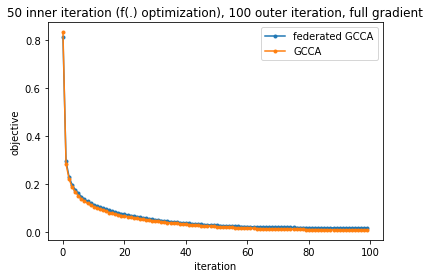

In [13]:
# fig, axes = plt.subplots(1,2, figsize=(10,10))
# plt.figsize=(20, 20)

plt.plot(df3['data_fidelity']*1000, marker='.')
plt.plot(df2['data_fidelity']*1000, marker='.')
plt.legend(['federated GCCA', 'GCCA'])
plt.xlabel('iteration')
plt.ylabel('objective')
plt.title('50 inner iteration (f(.) optimization), 100 outer iteration, full gradient')

plt.savefig('plt/convergence_cifar.pdf')

In [11]:
import time
# a = torch.randn(50000,32,32)

for i in range(10):
    time.sleep(3)
    a = torch.randn(50000,32,32)
    time.sleep(1)
    print('next')
    del a
    print('deleted')

next
deleted
next
deleted
next
deleted
next
deleted
next
deleted
next
deleted


KeyboardInterrupt: 

In [3]:
a.data.copy(torch.randn(50000,32,32).data)

AttributeError: 'Tensor' object has no attribute 'copy'

In [4]:
del a

In [5]:
50000*32*32

51.2

In [8]:
G.shape

torch.Size([5000, 10])

In [21]:
# train_loader = iter(train_loader)
    
train_views, classes = next(train_loader)


StopIteration: 

In [2]:
import numpy as np
from sklearn.manifold import TSNE
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape


(4, 2)

In [17]:
G.shape

torch.Size([50000, 10])

In [3]:
X = G[:5000].numpy()
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(5000, 2)

Text(0.5, 1.0, 't-SNE plot of latent representation G')

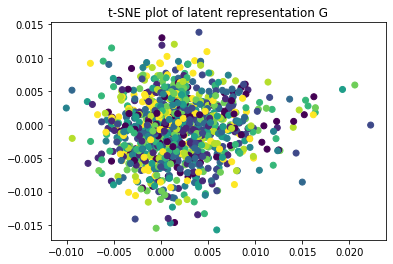

In [18]:
fig, axes = plt.subplots(1,1)

axes.scatter(X[:1000,0], X[:1000,1], c=train_classes[:1000].numpy())
axes.set_title('t-SNE plot of latent representation G')

In [19]:
fig.savefig('plt/tsne_cifar.pdf')

In [15]:
classes

tensor([6, 7, 9,  ..., 1, 1, 5])